In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
 
#Create spark configuration object
conf = SparkConf()
conf.setMaster("local").setAppName("My app")
 
#Create spark context and sparksession
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)
#set variable to be used to connect the database
database = "ETL_2"
table = "dbo.Aeropuerto"
user = "sa"
password  = r'Gali120"'
 
#read table data into a spark dataframe
jdbcDF = spark.read.format("jdbc") \
    .option("url", f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
    .option("dbtable", table) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .load()
 
#show the data loaded into dataframe
jdbcDF.show()

+-----+--------------------+-----+----------+-------+--------+----------+---------+
|sigla|              nombre|clase|      tipo|latitud|longitud|resolucion|categoria|
+-----+--------------------+-----+----------+-------+--------+----------+---------+
|  7FU|        LA ESCONDIDA|   1A|Fumigación| 4.6108|-71.1935|  1843,000|Aeródromo|
|  7FW|           MORICHITO|   1A|   Privado| 5.9188|-71.7932|  2220,000|Aeródromo|
|  7FX|CAROLINA DEL PRIN...|   1A|   Público| 6.7248|-75.2909|  6470,000|Aeródromo|
|  7FY|               DUBAI|   1A|   Privado|  8.296|-75.0307|  1212,000|Aeródromo|
|  7GA|  BARU - HIDROPUERTO|   1A|   Privado|10.2321|-75.5877|  6067,000|Aeródromo|
|  7GB|         LA CAROLINA|   UL|   Privado|  9.528|-73.7866|  5474,000|Aeródromo|
|  7GC|SAN FELIPE DEL PAUTO|   1A|   Privado| 5.2032|-70.8951|  4505,000|Aeródromo|
|  7GD|           VELASQUEZ|   3C|   Privado| 5.9482|-74.4575|  2135,000|Aeródromo|
|  7GF|            LA UNION|   1A|   Privado| 5.6283|-70.7032|  2136,000|Aer

In [2]:
import pandas as pd
import numpy as np 
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark import SparkFiles

# Carga de datos 

Los datos se encuentran almacenados en un repositorio de github

In [3]:
vuelos_url = 'https://raw.githubusercontent.com/MIAD-Modelo-Datos/Recursos/main/Infraestructura%20visible/Etapa%201/vuelos.csv'
spark.sparkContext.addFile(vuelos_url)
vuelos = spark.read.csv(SparkFiles.get("vuelos.csv"), header=True)

In [4]:
aeropuertos_url = 'https://raw.githubusercontent.com/MIAD-Modelo-Datos/Recursos/main/Infraestructura%20visible/Etapa%201/aeropuertos.csv'
spark.sparkContext.addFile(aeropuertos_url)
aeropuertos = spark.read.csv(SparkFiles.get("aeropuertos.csv"), header=True)

# Transformacion de datos 

La idea es modificar los datos de tal forma que se adapten al modelo de estrella propuesto. Se va a comenzar primera creando el modelo correspondiente a registrar vuelos 

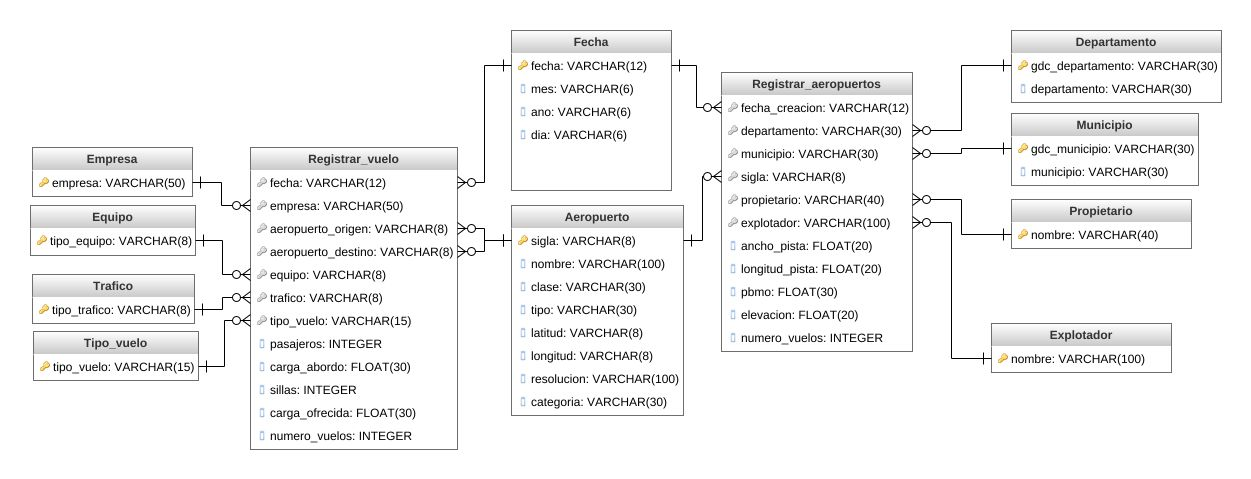

## Dimensión Fecha 

In [5]:
vuelos = vuelos.withColumn('dia', functions.lit('1'))
vuelos = vuelos.withColumn('fecha', functions.concat_ws('-',vuelos.dia , vuelos.mes, vuelos.ano))

In [6]:
dimension_fecha = vuelos.select(['ano','mes','dia'])
dimension_fecha = dimension_fecha.withColumn('fecha', functions.concat_ws('-',dimension_fecha.dia , dimension_fecha.mes, dimension_fecha.ano))
dimension_fecha = dimension_fecha.dropDuplicates()

## Dimensión Aeropuerto

In [7]:
dimension_aeropuerto = aeropuertos.select(['sigla','nombre', 'clase','tipo','latitud','longitud','resolucion','categoria'])
#dimension_aeropuerto = dimension_aeropuerto.dropDuplicates()
dimension_aeropuerto = dimension_aeropuerto.dropDuplicates((['sigla']))

## Dimensión Empresa

In [8]:
dimension_empresa = vuelos.selectExpr('empresa as empresa').dropDuplicates()

## Equipo

In [9]:
dimension_equipo = vuelos.select('tipo_equipo').dropDuplicates() 

## Trafico

In [10]:
dimension_trafico = vuelos.selectExpr('trafico as tipo_trafico').dropDuplicates() 

## Tipo vuelo

In [11]:
dimension_tipo_vuelo = vuelos.select('tipo_vuelo').dropDuplicates() 

## Registrar vuelo

In [33]:
fact_registrar_vuelos = vuelos.selectExpr('fecha', 'empresa','origen as aeropuerto_origen', 'destino as aeropuerto_destino', 'tipo_equipo as equipo','trafico','tipo_vuelo','pasajeros','carga_bordo as carga_abordo','sillas','carga_ofrecida','vuelos as numero_vuelos')

In [27]:
fact_registrar_vuelos.show()

+---------+--------------------+-----------------+------------------+------+-------+----------+---------+------------------+------+--------------+-------------+
|    fecha|             empresa|aeropuerto_origen|aeropuerto_destino|equipo|trafico|tipo_vuelo|pasajeros|      carga_abordo|sillas|carga_ofrecida|numero_vuelos|
+---------+--------------------+-----------------+------------------+------+-------+----------+---------+------------------+------+--------------+-------------+
| 1-1-2012|             RIO SUR|              BOG|               CUC|  BE20|      N|         T|      4.0|             100.0|   0.0|           0.0|          1.0|
| 1-5-2013|               AIRES|              UIB|               BOG|  DH8D|      N|         R|    873.0|            4222.0|1110.0|       24000.0|         30.0|
|1-10-2013|               AIRES|              IBE|               BOG|  DH8D|      N|         R|   2866.0|           2323.75|3626.0|       56056.0|         98.0|
| 1-4-2012|         SARPA S.A.S|  

## Departamento

In [37]:
dimension_departamento = aeropuertos.selectExpr('gcd_departamento as gdc_departamento', 'departamento')
dimension_departamento = dimension_departamento.dropDuplicates((['gdc_departamento']))

## Municipio

In [47]:
dimension_municipio = aeropuertos.selectExpr('gcd_municipio as gdc_municipio', 'municipio')
dimension_municipio = dimension_municipio.dropDuplicates((['gdc_municipio']))

## Propietario

In [56]:
dimension_propietario = aeropuertos.selectExpr('propietario as nombre')
dimension_propietario = dimension_propietario.dropDuplicates((['nombre']))

## Explotador

In [57]:
dimension_explotador = aeropuertos.selectExpr('explotador as nombre')
dimension_explotador = dimension_explotador.dropDuplicates((['nombre']))

## Registrar aeropuerto

In [129]:
dimension_registrar_aeropuerto = aeropuertos.selectExpr('fecha_construccion as fecha_creacion', 'gcd_departamento as departamento','gcd_municipio as municipio','sigla','propietario','explotador','ancho_pista','longitud_pista','pbmo','elevacion','numero_vuelos_origen as numero_vuelos')
dimension_registrar_aeropuerto = dimension_registrar_aeropuerto.withColumn('ano', functions.substring('fecha_creacion', 1,4))
dimension_registrar_aeropuerto = dimension_registrar_aeropuerto.withColumn('mes', functions.substring('fecha_creacion', 6,2))
dimension_registrar_aeropuerto = dimension_registrar_aeropuerto.withColumn('dia', functions.substring('fecha_creacion', 9,2))
dimension_registrar_aeropuerto = dimension_registrar_aeropuerto.withColumn('fecha_creacion', functions.concat_ws('-',dimension_registrar_aeropuerto.dia , dimension_registrar_aeropuerto.mes, dimension_registrar_aeropuerto.ano))


In [130]:
dimension_fecha_2 = dimension_registrar_aeropuerto.selectExpr('fecha_creacion as fecha', 'dia','mes','ano').dropDuplicates()

In [131]:
dimension_registrar_aeropuerto = dimension_registrar_aeropuerto.drop('ano','mes','dia')

In [132]:
dimension_fecha_2.show()

+----------+---+---+----+
|     fecha|dia|mes| ano|
+----------+---+---+----+
|08-08-2016| 08| 08|2016|
|19-02-1958| 19| 02|1958|
|04-09-2017| 04| 09|2017|
|30-12-2012| 30| 12|2012|
|19-09-2012| 19| 09|2012|
|18-04-2013| 18| 04|2013|
|23-04-1969| 23| 04|1969|
|14-10-2014| 14| 10|2014|
|10-11-2016| 10| 11|2016|
|17-08-1960| 17| 08|1960|
|08-04-1981| 08| 04|1981|
|19-11-1973| 19| 11|1973|
|07-05-2012| 07| 05|2012|
|10-07-1968| 10| 07|1968|
|23-03-2012| 23| 03|2012|
|15-09-1969| 15| 09|1969|
|30-10-1990| 30| 10|1990|
|29-12-2015| 29| 12|2015|
|27-10-2006| 27| 10|2006|
|25-11-2012| 25| 11|2012|
+----------+---+---+----+
only showing top 20 rows



In [135]:
dimension_fecha_2 = dimension_fecha_2.join(dimension_fecha, ["fecha", "fecha"], "leftanti")

In [144]:
dimension_fecha_2 = dimension_fecha_2.select(dimension_fecha_2.columns[1:5])

# Loading Data

## Fecha

In [42]:
dimension_fecha.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Fecha') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

Py4JJavaError: An error occurred while calling o313.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 62.0 failed 1 times, most recent failure: Lost task 0.0 in stage 62.0 (TID 38) (LAPTOP-3A2P2DP8 executor driver): java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Fecha__E1141323C23F2F16'. Cannot insert duplicate key in object 'dbo.Fecha'. The duplicate key value is (1-3-2010).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1020)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1018)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:888)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:69)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Fecha__E1141323C23F2F16'. Cannot insert duplicate key in object 'dbo.Fecha'. The duplicate key value is (1-3-2010).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


## Aeropuerto

In [20]:
dimension_aeropuerto.show()

+-----+--------------------+-----+----------+-------+--------+----------+---------+
|sigla|              nombre|clase|      tipo|latitud|longitud|resolucion|categoria|
+-----+--------------------+-----+----------+-------+--------+----------+---------+
|  7FU|        LA ESCONDIDA|   1A|Fumigación| 4.6108|-71.1935|  1843,000|Aeródromo|
|  7FW|           MORICHITO|   1A|   Privado| 5.9188|-71.7932|  2220,000|Aeródromo|
|  7FX|CAROLINA DEL PRIN...|   1A|   Público| 6.7248|-75.2909|  6470,000|Aeródromo|
|  7FY|               DUBAI|   1A|   Privado|  8.296|-75.0307|  1212,000|Aeródromo|
|  7GA|  BARU - HIDROPUERTO|   1A|   Privado|10.2321|-75.5877|  6067,000|Aeródromo|
|  7GB|         LA CAROLINA|   UL|   Privado|  9.528|-73.7866|  5474,000|Aeródromo|
|  7GC|SAN FELIPE DEL PAUTO|   1A|   Privado| 5.2032|-70.8951|  4505,000|Aeródromo|
|  7GD|           VELASQUEZ|   3C|   Privado| 5.9482|-74.4575|  2135,000|Aeródromo|
|  7GF|            LA UNION|   1A|   Privado| 5.6283|-70.7032|  2136,000|Aer

In [18]:
dimension_aeropuerto.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Aeropuerto') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

Py4JJavaError: An error occurred while calling o127.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 1 times, most recent failure: Lost task 0.0 in stage 11.0 (TID 8) (LAPTOP-3A2P2DP8 executor driver): java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Aeropuer__3C47D518E910447D'. Cannot insert duplicate key in object 'dbo.Aeropuerto'. The duplicate key value is (7FU).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1020)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1018)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:888)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:69)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Aeropuer__3C47D518E910447D'. Cannot insert duplicate key in object 'dbo.Aeropuerto'. The duplicate key value is (7FU).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


## Empresa

In [56]:
dimension_empresa.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Empresa') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Equipo

In [43]:
dimension_equipo.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Equipo') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

Py4JJavaError: An error occurred while calling o327.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 65.0 failed 1 times, most recent failure: Lost task 0.0 in stage 65.0 (TID 40) (LAPTOP-3A2P2DP8 executor driver): java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Equipo__4A38CA2082150F63'. Cannot insert duplicate key in object 'dbo.Equipo'. The duplicate key value is (BE30).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1020)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1018)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:888)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:69)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:110)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:106)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:106)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:93)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:91)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:128)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:848)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:382)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:355)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.sql.BatchUpdateException: Violation of PRIMARY KEY constraint 'PK__Equipo__4A38CA2082150F63'. Cannot insert duplicate key in object 'dbo.Equipo'. The duplicate key value is (BE30).
	at com.microsoft.sqlserver.jdbc.SQLServerPreparedStatement.executeBatch(SQLServerPreparedStatement.java:1870)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:728)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:890)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1020)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1020)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


## Trafico

In [59]:
dimension_trafico.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Trafico') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Tipo vuelo

In [60]:
dimension_tipo_vuelo.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Tipo_vuelo') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Registrar Vuelo

In [36]:
fact_registrar_vuelos.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Registrar_vuelo') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Fechas de aeropuertos 

In [146]:
dimension_fecha_2.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Fecha') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Departamento

In [149]:
dimension_departamento.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Departamento') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

AnalysisException: Column "gdc_departamento" not found in schema Some(StructType(StructField(gdc_municipio,StringType,false), StructField(municipio,StringType,true)))

## Municipio 

In [150]:
dimension_municipio.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Municipio') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Explotador

In [152]:
dimension_explotador.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Explotador') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Propietario

In [153]:
dimension_propietario.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Propietario') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()

## Registrar Aeropuerto

In [154]:
dimension_registrar_aeropuerto.select('*').write.format('jdbc') \
          .mode('append') \
          .option('url', f"jdbc:sqlserver://localhost:1433;databaseName={database};") \
          .option('dbtable', 'Registrar_aeropuertos') \
          .option('user', user) \
          .option('password', password) \
          .option('driver', "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
          .save()